# Chap04 - Word2Vec 속도 개선

[Chap03](https://github.com/ExcelsiorCJH/DLFromScratch2/tree/master/Chap03-Word2Vec)에서 구현한 CBOW를 복습해본다.
<br><br>
CBOW모델은 단어 2개를 맥략으로 사용해 이를 바탕으로 하나의 단어(타깃)을 추출 <BR><BR>
![](./images/fig_4_1.png)

In [ ]:
## CBOW 복습
from common.optimizer import Adam
from common.util import preprocess, create_contexts_target, convert_one_hot
from common.layers import MatMul, SoftmaxWithLoss
import time
import numpy as np
import numpy
import matplotlib.pyplot as plt
from common.trainer import Trainer

window_size = 1
hidden_size = 5
batch_size = 5
max_epoch = 300

text = 'You say goodbye an I say hello'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
context, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
context = convert_one_hot(context, vocab_size)

class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        
        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')
        
        # 레이어 생성
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()
        
        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads           
        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs1 = W_in
        self.word_vecs2 = W_out.T
        
    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss
    
    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None


model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)
\
trainer.fit(context, target, max_epoch, batch_size, eval_interval=100)
trainer.plot()

In [2]:
###########################################################################################
# 기타 모듈 확인
###########################################################################################

class Trainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.loss_list = []
        self.eval_interval = None
        self.current_epoch = 0           
    def fit(self, x, t, max_epoch=10,
            batch_size=32, max_grad=None, eval_interval=20):
        data_size = len(x)
        max_iters = data_size // batch_size
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0
        start_time = time.time()
        for epoch in range(max_epoch):
            # 뒤섞기
            idx = np.random.permutation(np.arange(data_size))
            x = x[idx]
            t = t[idx]
            for iters in range(max_iters):
                batch_x = x[iters*batch_size:(iters+1)*batch_size]
                batch_t = t[iters*batch_size:(iters+1)*batch_size]

                # 기울기 구해 매개변수 갱신
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 공유된 가중치를 하나로 모음
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # 평가
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    avg_loss = total_loss / loss_count
                    elapsed_time = time.time() - start_time
                    print('| 에폭 %d |  반복 %d / %d | 시간 %d[s] | 손실 %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, avg_loss))
                    self.loss_list.append(float(avg_loss))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1
    def plot(self, ylim=None):
        x = numpy.arange(len(self.loss_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.loss_list, label='train')
        plt.xlabel('Iterations (x' + str(self.eval_interval) + ')')
        plt.ylabel('Loss')
        plt.show()
'''
매개변수 배열 중 중복되는 가중치를 하나로 모아
그 가중치에 대응하는 기울기를 더한다.
'''        
def remove_duplicate(params, grads):
    params, grads = params[:], grads[:]  # copy list
    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                # 가중치 공유 시
                if params[i] is params[j]:
                    grads[i] += grads[j]  # 경사를 더함
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                # 가중치를 전치행렬로 공유하는 경우(weight tying)
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                if find_flg: break
            if find_flg: break
        if not find_flg: break
    return params, grads
###########################################################################################
###########################################################################################

[Chap03](https://github.com/ExcelsiorCJH/DLFromScratch2/tree/master/Chap03-Word2Vec)에서 살펴본 CBOW 모델의 구조는 다음과 같은 문제가 있다.

- 말뭉치(corpus)에 포함된 어휘 수가 많아지면 계산량이 커진다.

이를 해결하기 위해 이번 장에서는 두 가지 개선을 추가한다.

1. `Embedding` 레이어를 도입한다.
2. 네거티브 샘플링(NEG, Negative Sampling)이라는 새로운 손실함수를 도입한다.

> 이번장에서 배울 내용
> - Embedding의 계층은 단어의 분산 표현을 담고 있으며, 순전파시 지정한 단어 ID의 벡터를 추출한다.
> - word2vec은 어휘수의 증가에 비례하여 계산량도 증가하므로 근사치로 계산하는 빠른 기법을 사용하면 좋다.
> - word2vec로 얻은 단어의 분산 표형에는 단어의 의미가 녹아들어있으며 비슷한 맥락에서 사용하는 단어는 단어 벡터공간에서 가까이 위치한다.
> - word2vec의 단어 분산표현을 이용하면 유추문제를 백터의 덧셈과 뺄셈으로 풀수 있게 된다.
> - word2vec은 전이학습 측면에서 특히 중요하며, 그 단어의 분산 표현은 다양한 자연어 처리작업에 이용할 수 있다

## 4.1 Word2Vec 개선 ①

CBOW 모델의 문제점은 아래의 그림에서 확인할 수 있듯이 예를 들어, 어휘가 100만개, 은닉층의 뉴런이 100개인 CBOW 모델의 경우에는 다음의 두 계산이 병목(bottleneck)이 된다.

- 입력층의 원핫(one-hot) 표현과 가중치 행렬 $\mathbf{W}_{\text{in}}$의 곱 계산

- 은닉층과 가중치 행렬 $\mathbf{W}_{\text{out}}$의 곱 및 `Softmax`(특히 분모)의 계산

<img src="./DLFromScratch2/Chap04-Word2Vec_Improved/images/cbow_big.png" width="65%" height="65%" />

### 4.1.1 Embedding 계층

각 단어(어휘)를 원핫 표현으로 변환한 다음 가중치 행렬을 곱해주는 작업은 **결과적으로 단지 각 단어에 해당하는 특정 행을 추출**하는 것 뿐이다. 따라서, 원핫 표현으로의 변환과 가중치 행렬 곱 계산은 사실상 필요하지 않다.

![](./DLFromScratch2/Chap04-Word2Vec_Improved/images/embedding.png)

### 4.1.2 Embedding 계층 구현

In [3]:
import numpy as np

W = np.arange(21).reshape(7, 3)
W

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11],
       [12, 13, 14],
       [15, 16, 17],
       [18, 19, 20]])

In [4]:
# 두 번째 행 가져오기
# -> index=2에 해당하는 단어 벡터
W[2]

array([6, 7, 8])

In [5]:
W[5]

array([15, 16, 17])

In [6]:
# 가중치 W로 부터 여러행을 한꺼번에 추출
idx = np.array([1, 0, 3, 0])
W[idx]

array([[ 3,  4,  5],
       [ 0,  1,  2],
       [ 9, 10, 11],
       [ 0,  1,  2]])

In [7]:
# Embedding Layer 구현
# commons/layers.py
class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None
        
    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out
    
    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        np.add.at(dW, self.idx, dout)
        
        # 혹은 
        # for i, word_id in enumerate(self.idx):
        #     dW[word_id] += dout[i]
        
        return None

- 가중치기울기 dW를 꺼낸다음 dW[...] = 0 문장에서 dW의 원소를 0으로 덮어씀.
   - (dW의 형상을 유지한 채 그 원소들을 0으로 덮어쓰는 것
- 앞에서 전해진 기울기 dout은 idx번째 행에 할당
> 가중치W와 크기가 같은 행렬 dW를 만들고,  dW의 특정 행에 기울기를 할당했음. 최종적으로 하고 싶은 일은 가중치 W를 갱신하는 것이므로 일부러 dW와 같은 행렬을 만들 필요는 없음. 갱신하려는 행번호(idx)와 그 기울기(dout)을 따로 저장해두면 이정보로부터 가중치(W)의 특정행만 갱신할 수 있음 여기서는 이미 구현해둔 갱신용클래스( Optimizer)와 조합사용을 고려
- MatMul 계층대신 위와 같은 Embedding 계층을 사용하게 되어 메모리 사용량도 줄이고 쓸데없는 계산도 생략하게 됨

## 4.2 Word2Vec 개선 ②

4.1에서는 `Input - hidden`의 병목을 `Embedding`이라는 새로운 레이어를 도입해주면서 해결했고, 이번에는 `hidden - output`의 병목을 **Negative Sampling**을 통해 해결한다.

### 4.2.1 은닉층 이후 계산의 문제점

아래의 그림처럼 100만개의 단어에 대해 Softmax를 구하게 되면 계산량이 많아지는 문제가 있다.


$$
y_k = \frac{\exp{(s_k)}}{\sum_{i=1}^{1000000}{\exp{(s_i)}}}
$$

<img src="./DLFromScratch2/Chap04-Word2Vec_Improved/images/cbow_big2.png" width="50%" height="50%" />

### 4.2.2 다중 분류에서 이진 분류로

Negative Sampling(NEG)의 핵심 아이디어는 **'이진 분류'**<sup>binary classificaton</sup>에 있다. 즉, '다중 분류<sup>multi-class classification</sup>'를 '이진 분류'로 근사하는 것이 Negative Sampling을 이해하는 데 중요한 포인트다.

>  이진분류는 'Y/N' 로 답하는 문제를 주로 다룸. 
> - 출력층의 뉴런이 하나뿐이므로, 'say'에 해당하는 열벡터를 추출하여 가져오면, 타깃단어는 say입니까? 'Y/N'로 답할 수 있음

![](./images/fig4_8.png)

### 4.2.3 시그모이드 함수와 교차 엔트로피 오차

다중 분류의 경우에는 출력층에서 점수<sup>score</sup>를 확률로 변환할 때, 소프트맥스 함수를 사용하고, 이진 분류의 경우에는 시그모이드 함수를 사용한다. 


$$
y = \frac{1}{1 + \exp{(-x)}}
$$

시그모이드 함수를 적용해 확률 $y$를 구한 후, 이 확률 $y$로 부터 손실(Loss)을 구한다.


$$
L = - \left[ t \log{y} + (1-t) \log{(1-y)} \right]
$$

'Sigmoid with Loss' 레이어의 역전파를 구하면 다음과 같다.

$$
\begin{align*}
\frac{\partial L}{\partial x} &= \frac{\partial L}{\partial y} \frac{\partial y}{\partial x} = y-t \\
\frac{\partial L}{\partial y} &= -\frac{t}{y} + \frac{1-t}{1-y} = \frac{y-t}{y(1-y)} \\
\frac{\partial y}{\partial x} &= y(1-y)
\end{align*}
$$

<img src="./DLFromScratch2/Chap04-Word2Vec_Improved/images/sigmoid02.png" width="70%" height="70%" />

위의 식에서 'Sigmoid with Loss'레이어에서의 역전파는 $y-t$ 즉, 오차가 앞의 계층으로 흘러가게 된다. 따라서, 오차가 크면 '크게'학습하고, 오차가 작으면 '작게'학습하게 된다.

### 4.2.4 다중 분류에서 이진 분류로(구현)

![](./DLFromScratch2/Chap04-Word2Vec_Improved/images/cbow.png)

In [8]:
# Chap04/negative_sampling_layer.py
import sys
sys.path.append('..')
import collections
from common.np import *
from common.layers import Embedding, SigmoidWithLoss

In [9]:
class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None
        
    def forward(self, h, idx):
        target_W = self.embed.forward(idx)
        out = np.sum(target_W * h, axis=1)
        
        self.cache = (h, target_W)
        return out
    
    def backward(self, dout):
        h, target_W = self.cache
        dout = dout.reshape(dout.shape[0], 1)
        
        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh

![](./images/fig4_14.png)

### 4.2.5 네거티브 샘플링

다중 분류 문제를 이진 분류로 바꾸면서 `(입력, 타깃)`의 정답인 예제와 오답(`window_size`내에 포함 되어 있지 않은 단어 쌍)인 네거티브 샘플을 사용한다. 여기서 네거티브 샘플은 모든 단어에 대한 네거티브 샘플이 아니라 몇 개(5개 또는 10개) 정도를 선택하여, 즉 샘플링해 사용한다. 

Word2Vec의 학습 단계에서는 정답 데이터 쌍에 대해서는 1에 가깝게 예측하도록 학습하고, 오답(네거티브 샘플) 데이터 쌍에 대해서는 0에 가깝게 예측하도록 학습한다.

![](./images/fig_4_15.png)

> 위의 신경망에서는 say에 대해서만 학습하며, 부정적 예에 대해서는 어떠한 지식도 획득 못함
> - 정말 하고 싶은 것은 'say'에 대해서ㅏ는 sigmoid출력을 1에 가깝게, 그외의 단어는 0에 가깝게 만드는 것

<br><br>
![](./images/fig_4_16.png)

> 모든 부정적 예를 대상으로 이진분류를 학습해도 어휘수 늘어나면 비효율. 
> 따라서 근사 해법으로 적은수의 부정적 예를 몇 개 (5개 or10개) 선택하여 샘플링
> - 이것이 바로 '네거티브 샘플링' 
<br>

![](./images/fig_4_17.png)

### 4.2.6 네거티브 샘플링의 샘플링 기법

네거티브 샘플링 방법에는 단순히 랜덤하게 샘플링하는 것이 아니라, 말뭉치(corpus)에서 각 단어에 대한 확률분포로 단어를 샘플링한다. 확률분포에서 샘플링하기 때문에 말뭉치에서 자주 등장하는 단어는 샘플링 될 가능성이 높고, '희소한 단어'는 선택되기 어렵다. '희소한 단어'는 실제로 많이 등장하는 단어가 아니기 때문에 이러한 드문 단어를 잘 처리하는 것은 중요하지 않으며, 차라리 흔한 단어를 잘 처리하는 편이 결과가 더 좋다.

![](./DLFromScratch2/Chap04-Word2Vec_Improved/images/neg2.png)

In [10]:
# 확률분포에 따른 샘플링 예제
import numpy as np

# 0에서 9까지의 숫자 중 하나를 랜덤하게 샘플링
np.random.choice(10)

5

In [11]:
np.random.choice(10)

2

In [34]:
# words에서 하나만 무작위로 샘플링
words = ['you', 'say', 'goodbye', 'i', 'hello', '.']
np.random.choice(words)

# 5개만 무작위로 샘플링(중복 없음)
np.random.choice(words, size=5, replace=False)

# 확률분포에 따라 샘플링
p = [0.5, 0.1, 0.05, 0.2, 0.05, 0.1]
np.random.choice(words, p=p)

'you'

#### Word2Vec에서의 네거티브 샘플링

Word2Vec에서의 확률분포는 기본 확률분포(Unigram Distribution)에 $\frac{3}{4} = 0.75$를 제곱해준다.


$$
P'(w_i) = \frac{P(w_i)^{0.75}}{\sum_{j}^{n}{p(w_j)^{0.75}}}
$$

아래의 예제에서 확인할 수 있듯이, 낮은 확률의 단어가 (조금 더) 쉽게 샘플링되도록 하기 위함이다.

In [15]:
p = [0.7, 0.29, 0.01]
new_p = np.power(p, 0.75)

new_p /= np.sum(new_p)
print(new_p)

[0.64196878 0.33150408 0.02652714]


In [35]:
import sys
sys.path.append('..')
from common.np import *  # import numpy as np
from common.layers import Embedding, SigmoidWithLoss
import collections

# Negative Sampling 클래스 구현
# chap04/negative_sampling_layer.py
class UnigramSampler:
    def __init__(self, corpus, power, sample_size):
        self.sample_size = sample_size
        self.vocab_size = None
        self.word_p = None
        
        counts = collections.Counter()
        for word_id in corpus:
            counts[word_id] += 1
            
        vocab_size = len(counts)
        self.vocab_size = vocab_size
        
        self.word_p = np.zeros(vocab_size)
        for i in range(vocab_size):
            self.word_p[i] = counts[i]
            
        self.word_p = np.power(self.word_p, power)
        self.word_p /= np.sum(self.word_p)
        
    def get_negative_sample(self, target):
        batch_size = target.shape[0]
        
        if not GPU:  # == CPU
            negative_sample = np.zeros((batch_size, self.sample_size), dtype=np.int32)
            
            for i in range(batch_size):
                p = self.word_p.copy()
                target_idx = target[i]
                p[target_idx] = 0  # target이 뽑히지 않게 하기 위함
                p /= p.sum()  # 다시 정규화 해줌
                negative_sample[i, :] = np.random.choice(self.vocab_size,
                                                         size=self.sample_size,
                                                         replace=False, p=p)
                
        else:
            # GPU(cupy)로 계산할 때는 속도를 우선한다.
            # 부정적 예에 타깃이 포함될 수 있다.
            negative_sample = np.random.choice(self.vocab_size, 
                                               size=(batch_size, self.sample_size), 
                                               replace=True, p=self.word_p)
            
        return negative_sample

In [36]:
corpus = np.array([0, 1, 2, 3, 4, 1, 2, 3])
power = 0.75
sample_size = 2

# 각각의 데이터에 대해 부정적 예를 2개씩 샘플링
sampler = UnigramSampler(corpus, power, sample_size)

# 긍정적 예로 [1.3,0]이라는 3개의 데이터를 미니배치로 다룸 
target = np.array([1, 3, 0])
negative_sample = sampler.get_negative_sample(target)
print(negative_sample)

[[0 2]
 [2 4]
 [2 1]]


### 4.2.7 네거티브 샘플링 구현

In [18]:
import sys
sys.path.append('..')
from common.np import *  # import numpy as np
from common.layers import Embedding, SigmoidWithLoss
import collections

In [19]:
# chap04/negative_sampling_layer.py
class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size 
        self.sampler = UnigramSampler(corpus, power, sample_size)
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)]
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]
        
        self.params, self.grads = [], []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def forward(self, h, target):
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(target)
        
        # 긍정적 예 순전파
        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32)
        loss = self.loss_layers[0].forward(score, correct_label)
        
        # 부정적 예 순전파
        negative_label = np.zeros(batch_size, dtype=np.int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i]  # embed_dot에 해당하는 타겟이라는 의미인 듯
            score = self.embed_dot_layers[1 + i].forward(h, negative_target)
            loss += self.loss_layers[1 + i].forward(score, negative_label)
            
        return loss
    
    def backward(self, dout=1):
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)
        
        return dh

## 4.3 개선판 Word2Vec 학습

### 4.3.1 CBOW 모델 구현

In [20]:
# chap04/cbow.py
import sys
sys.path.append('..')
from common.np import *
from common.layers import Embedding
from negative_sampling_layer import NegativeSamplingLoss

In [21]:
class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size
        
        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')
        
        # 레이어 생성
        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)  # Embedding 계층 사용
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)
        
        # 모든 가중치와 기울기를 배열에 모은다.
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs1 = W_in
        self.word_vecs2 = W_out
        
    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)  # average
        loss = self.ns_loss.forward(h, target)
        return loss
    
    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None

### 4.3.2 CBOW 모델 학습 코드

In [22]:
# chap04/train.py
import sys
sys.path.append('..')
import numpy as np
from common import config
# GPU에서 실행하려면 아래 주석을 해제하세요(CuPy 필요).
# ===============================================
config.GPU = True
# ===============================================
import pickle
from common.trainer import Trainer
from common.optimizer import Adam
from cbow import CBOW
from skip_gram import SkipGram
from common.util import create_contexts_target, to_cpu, to_gpu
from dataset import ptb

In [23]:
# Embedding Layer 구현
# https://velog.io/@a01152a/word2vec-%EC%86%8D%EB%8F%84-%EA%B0%9C%EC%84%A02

import cupyx
class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None
        
    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out
    
    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        if GPU:
            cupyx.scatter_add(dW, self.idx, dout)
        else:
            np.add.at(dW, self.idx, dout)
        return None

| 에폭 1 |  반복 1 / 9295 | 시간 0[s] | 손실 4.16
| 에폭 1 |  반복 2001 / 9295 | 시간 89[s] | 손실 2.71
| 에폭 1 |  반복 4001 / 9295 | 시간 178[s] | 손실 2.45
| 에폭 1 |  반복 6001 / 9295 | 시간 267[s] | 손실 2.36
| 에폭 1 |  반복 8001 / 9295 | 시간 356[s] | 손실 2.29
| 에폭 2 |  반복 1 / 9295 | 시간 415[s] | 손실 2.23
| 에폭 2 |  반복 2001 / 9295 | 시간 505[s] | 손실 2.15
| 에폭 2 |  반복 4001 / 9295 | 시간 593[s] | 손실 2.11
| 에폭 2 |  반복 6001 / 9295 | 시간 683[s] | 손실 2.08
| 에폭 2 |  반복 8001 / 9295 | 시간 772[s] | 손실 2.04
| 에폭 3 |  반복 1 / 9295 | 시간 829[s] | 손실 2.02
| 에폭 3 |  반복 2001 / 9295 | 시간 919[s] | 손실 1.94
| 에폭 3 |  반복 4001 / 9295 | 시간 1008[s] | 손실 1.93
| 에폭 3 |  반복 6001 / 9295 | 시간 1098[s] | 손실 1.92
| 에폭 3 |  반복 8001 / 9295 | 시간 1188[s] | 손실 1.90
| 에폭 4 |  반복 1 / 9295 | 시간 1246[s] | 손실 1.89
| 에폭 4 |  반복 2001 / 9295 | 시간 1334[s] | 손실 1.82
| 에폭 4 |  반복 4001 / 9295 | 시간 1423[s] | 손실 1.82
| 에폭 4 |  반복 6001 / 9295 | 시간 1513[s] | 손실 1.81
| 에폭 4 |  반복 8001 / 9295 | 시간 1602[s] | 손실 1.80
| 에폭 5 |  반복 1 / 9295 | 시간 1659[s] | 손실 1.79
| 에폭 5 |  반복 2001 / 92

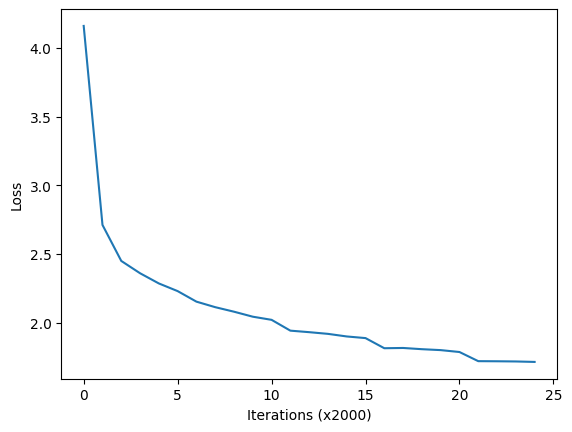

In [24]:
# 하이퍼파라미터 설정
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 5

# 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
if config.GPU:
    contexts, target = to_gpu(contexts), to_gpu(target)
# 모델 등 생성
model = CBOW(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)
# 학습 시작
trainer.fit(contexts.get(), target.get(), max_epoch, batch_size, eval_interval=2000)
trainer.plot()

# 나중에 사용할 수 있도록 필요한 데이터 저장
word_vecs = model.word_vecs1
if config.GPU:
    word_vecs = to_cpu(word_vecs)
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = './output/CBOW_100_5.pkl'

with open(pkl_file, 'wb') as f:
    pickle.dump(params, f,-1)

| 에폭 1 |  반복 1 / 9295 | 시간 0[s] | 손실 41.59
| 에폭 1 |  반복 2001 / 9295 | 시간 413[s] | 손실 28.09
| 에폭 1 |  반복 4001 / 9295 | 시간 836[s] | 손실 24.99
| 에폭 1 |  반복 6001 / 9295 | 시간 1248[s] | 손실 24.53
| 에폭 1 |  반복 8001 / 9295 | 시간 1660[s] | 손실 24.28
| 에폭 2 |  반복 1 / 9295 | 시간 1927[s] | 손실 24.16
| 에폭 2 |  반복 2001 / 9295 | 시간 2339[s] | 손실 23.96
| 에폭 2 |  반복 4001 / 9295 | 시간 2752[s] | 손실 23.91
| 에폭 2 |  반복 6001 / 9295 | 시간 3164[s] | 손실 23.84
| 에폭 2 |  반복 8001 / 9295 | 시간 3576[s] | 손실 23.77
| 에폭 3 |  반복 1 / 9295 | 시간 3843[s] | 손실 23.75
| 에폭 3 |  반복 2001 / 9295 | 시간 4255[s] | 손실 23.48
| 에폭 3 |  반복 4001 / 9295 | 시간 4667[s] | 손실 23.50
| 에폭 3 |  반복 6001 / 9295 | 시간 5079[s] | 손실 23.49
| 에폭 3 |  반복 8001 / 9295 | 시간 5491[s] | 손실 23.48
| 에폭 4 |  반복 1 / 9295 | 시간 5757[s] | 손실 23.46
| 에폭 4 |  반복 2001 / 9295 | 시간 6169[s] | 손실 23.20
| 에폭 4 |  반복 4001 / 9295 | 시간 6581[s] | 손실 23.23
| 에폭 4 |  반복 6001 / 9295 | 시간 6994[s] | 손실 23.24
| 에폭 4 |  반복 8001 / 9295 | 시간 7406[s] | 손실 23.25
| 에폭 5 |  반복 1 / 9295 | 시간 7673[s] | 

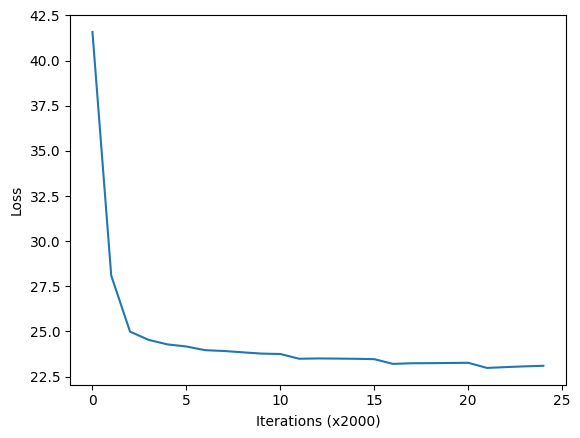

In [27]:
# 하이퍼파라미터 설정
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 5

# 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)
if config.GPU:
    contexts, target = to_gpu(contexts), to_gpu(target)
    
# 모델 등 생성
model = SkipGram(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# 학습 시작
trainer.fit(contexts.get(), target.get(), max_epoch, batch_size, eval_interval=2000)
trainer.plot()

# 나중에 사용할 수 있도록 필요한 데이터 저장
word_vecs = model.word_vecs
if config.GPU:
    word_vecs = to_cpu(word_vecs)
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = './output/SkipGram_100_5.pkl'

with open(pkl_file, 'wb') as f:
    pickle.dump(params, f,-1)

### 4.3.3 CBOW 모델 평가

In [28]:
import sys
sys.path.append('..')
import pickle
from common.util import most_similar, analogy

In [29]:
# pkl_file = './DLFromScratch2/Chap04-Word2Vec_Improved/cbow_params.pkl'
# with open(pkl_file, 'rb') as f:
#     params = pickle.load(f)

In [30]:
pkl_file = './output/CBOW_100_5.pkl'
with open(pkl_file, 'rb') as f:
    params = pickle.load(f)

In [31]:
word_vecs = params['word_vecs']
word_to_id = params['word_to_id']
id_to_word = params['id_to_word']

In [32]:
# 가장 비슷한(most similar) 단어 뽑기
querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] you
 we: 0.83935546875
 i: 0.80126953125
 someone: 0.71630859375
 your: 0.7080078125
 somebody: 0.7001953125

[query] year
 month: 0.9150390625
 week: 0.86083984375
 spring: 0.84375
 summer: 0.83642578125
 decade: 0.69775390625

[query] car
 truck: 0.765625
 machine: 0.7255859375
 disk: 0.69970703125
 supercomputer: 0.6884765625
 computer: 0.68603515625

[query] toyota
 nec: 0.80126953125
 weyerhaeuser: 0.7958984375
 honda: 0.767578125
 seita: 0.7451171875
 supermarkets: 0.74267578125


In [33]:
# 유추(analogy) 작업
print('-'*50)
analogy('king', 'man', 'queen',  word_to_id, id_to_word, word_vecs)
analogy('take', 'took', 'go',  word_to_id, id_to_word, word_vecs)
analogy('car', 'cars', 'child',  word_to_id, id_to_word, word_vecs)
analogy('good', 'better', 'bad',  word_to_id, id_to_word, word_vecs)

--------------------------------------------------

[analogy] king:man = queen:?
 woman: 5.59765625
 father: 5.02734375
 wife: 4.91796875
 husband: 4.703125
 mother: 4.6640625

[analogy] take:took = go:?
 were: 4.203125
 're: 4.1171875
 was: 4.109375
 are: 3.728515625
 went: 3.669921875

[analogy] car:cars = child:?
 a.m: 7.703125
 daffynition: 5.97265625
 rape: 5.33984375
 incest: 4.66796875
 women: 4.32421875

[analogy] good:better = bad:?
 rather: 5.671875
 more: 5.546875
 less: 5.15234375
 higher: 3.546875
 greater: 3.33984375
